In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [571]:
nodes = 6
gens = 2

gens_on_nodes = [0, 4]


fs = [lambda x : 0 for _ in range(nodes)]
fs[0] = lambda x: 0.67 * x[1] ** 2 + 26.24 * x[1] + 31.67
fs[4] = lambda x: 0.11 * x[1] ** 2 + 12.89 * x[1] + 6.78


dfs = [lambda x : np.zeros(len(x)) for _ in range(nodes)]
dfs[0] = lambda x: np.array([0, 2 * 0.67 * x[1] + 26.24])
dfs[4] = lambda x: np.array([0, 2 * 0.11 * x[1] + 12.89])

X = np.zeros((nodes, nodes))
X[0][1] = 0.6
X[0][2] = 0.6
X[1][3] = 0.1
X[2][4] = 0.1
X[3][4] = 0.1
X[0][5] = 0.1
X += X.T


B = -1/X

gens_bounds = [[20, 50], [200, 200]]
bounds_x = np.hstack(([[None]*nodes, [None]*nodes], gens_bounds))

np.nan_to_num(B, False, 0, 0, 0)

W0 = (B != 0) + 0.0
# W0 = np.ones(B.shape)
W0 = np.diag(W0.sum(axis=0)) - W0

B = np.diag(B.sum(axis=0)) - B  # admittance matrix
print('B', np.round(B))

G = np.zeros((nodes, gens))  # G_ij == 1 => gen # j on i'th node
gen_index = 0 
for i in gens_on_nodes:
    G[i][gen_index] = 1
    gen_index += 1
        
# G[0][0] = 1
# G[4][1] = 1

demand = np.zeros(nodes) # power demand
demand[2] = demand[3] = 150
demand[5] = 10

Flows = [] 
for i in range(nodes):
    for j in range(i):
        if B[i][j] != 0:
            Flows.append([0] * nodes)
            Flows[-1][i] = -B[i][j]
            Flows[-1][j] = B[i][j]
            

Flows = np.array(Flows)           
           
print(Flows.shape)
print('Flows', np.round(Flows))

# matrix for | (\teta_i - \teta_j) / X_ij | \leq F^max_ij constraint           
F = np.hstack((Flows, np.zeros((Flows.shape[0], gens))))

fmax = np.array([150] * F.shape[0])  # max flow

# subsystems flows bounds:
# case-2 partition





# Extended Laplacian:
print('W0 (for 1D variable)\n', W0)
            
def f_(x):
    p1, p2 = x[-gens:]
    return 0.67 * p1 ** 2 + 26.24 * p1 + 31.67 + 0.11 * p2 ** 2 + 12.89 * p2 + 6.78

def df_(x):
    p1, p2 = x[-gens:]
    return [0]* nodes + [2 * 0.67 * p1 + 26.24, 2 * 0.11 * p2 + 12.89]

# As = 

B [[-13.   2.   2.   0.   0.  10.]
 [  2. -12.   0.  10.   0.   0.]
 [  2.   0. -12.   0.  10.   0.]
 [  0.  10.   0. -20.  10.   0.]
 [  0.   0.  10.  10. -20.   0.]
 [ 10.   0.   0.   0.   0. -10.]]
(6, 6)
Flows [[  2.  -2.   0.   0.   0.   0.]
 [  2.   0.  -2.   0.   0.   0.]
 [  0.  10.   0. -10.   0.   0.]
 [  0.   0.  10.   0. -10.   0.]
 [  0.   0.   0.  10. -10.   0.]
 [ 10.   0.   0.   0.   0. -10.]]
W0 (for 1D variable)
 [[ 3. -1. -1.  0.  0. -1.]
 [-1.  2.  0. -1.  0.  0.]
 [-1.  0.  2.  0. -1.  0.]
 [ 0. -1.  0.  2. -1.  0.]
 [ 0.  0. -1. -1.  2.  0.]
 [-1.  0.  0.  0.  0.  1.]]


/tmp/ipykernel_85231/3314653346.py:26: RuntimeWarning: divide by zero encountered in true_divide
  B = -1/X


In [572]:
# check satisfiability of DC-PF constraint

e1 = np.zeros(nodes)
e1[0] = 1

gen_solution = np.array([110, 0, 0, 0, 200, 0])
b_ = np.hstack((gen_solution - d))
# B_ = np.vstack((B, e1))

B_ = B.copy()  # the system is singular: sum of rows = 0, so replace i'th (random) row with \theta_i = 0 constraint
B_[0] = e1
b_[0] = 0

# print(b_.shape, B_.shape)
x = np.linalg.solve(B_ , b_)
np.round(x)

# np.round(B @ x), b, np.round(B_ @ x)

ValueError: operands could not be broadcast together with shapes (6,) (12,) 

In [573]:
BG = np.hstack((B, -G)) # matrix for dc-power flow constraint
A = BG
b = -demand

C = np.vstack((F, -F))
d = np.hstack((fmax, fmax))

AC = np.vstack((A, C))
bd = np.hstack((b, d))

nodes_to_var_indices = [[i] for i in range(nodes)] 
gen_index = 0 
for i in gens_on_nodes:
    nodes_to_var_indices[i] = [i, nodes+gen_index]
    gen_index += 1
    
ACs = [AC[:, indices] for indices in nodes_to_var_indices]

# assign elements of bd to nodes
nodes_to_bd_indices = [[i] for i in range(nodes)]
for i in range(C.shape[0]):
    row = C[i]
#     print(np.round(row), np.where(row)[0][0])
    # assign to node with smaller index (try change)
    nodes_to_bd_indices[np.where(row)[0][0]].append(A.shape[0] + i)
    
print(bd)
print(nodes_to_bd_indices)

    
bds = []
for i in range(nodes):
    mask = np.zeros(len(bd))
    mask[nodes_to_bd_indices[i]] = 1
    bds.append(bd * mask)
    
assert(np.all(sum(bds) == bd))
# bd = bd_

[  -0.   -0. -150. -150.   -0.  -10.  150.  150.  150.  150.  150.  150.
  150.  150.  150.  150.  150.  150.]
[[0, 6, 7, 11, 12, 13, 17], [1, 8, 14], [2, 9, 15], [3, 10, 16], [4], [5]]


In [574]:
# i = 0
# ACs[i] @ get_xi(x, i) - get_bdi(bd, i)
W.shape, z.shape

((108, 108), (108,))

In [575]:
f(x), f_(x)

(17857.55639096769, 17857.55639096769)

In [590]:
# Ax - b constraint, BG - equality-type, F - inequaltiy-type
# A = np.vstack((BG, F, -F)) 
# b = np.hstack((-demand, fmax, fmax))


x_dim = nodes + gens
# x0 = np.array([0] * nodes + [100, 100] )

x = np.zeros(x_dim)
num_cons = AC.shape[0]
y = np.zeros(num_cons)
W = np.kron(W0, np.diag(np.ones(y.size)))
assert(np.all(W == W.T))

blowed_y = np.zeros(y.shape[0] * nodes)
z = np.zeros(np.shape(blowed_y))

h = 0.03

xs = []
x_s = []

bounds_y = [[None]*BG.shape[0] + [0] * (2 * F.shape[0]), [None]*AC.shape[0]]
y = blowed_y
bounds_y_blowed = [bounds_y[0] * nodes, bounds_y[1] * nodes]

def get_yi(y, i):
    return y[num_cons*i : num_cons*(i+1)]

def get_xi(x, i):
    return x[nodes_to_var_indices[i]]

def f(x):
    return sum([fs[i](get_xi(x, i)) for i in range(nodes)])

def df(x):
    grad = np.zeros(len(x))
    for i in range(nodes):
        indices = nodes_to_var_indices[i]
        grad[indices] = dfs[i](x[indices]) 
    return grad

def dLx(x, y):
    grad = df(x)
    for i in range(nodes):
        indices = nodes_to_var_indices[i]
        grad[indices] +=  ACs[i].T @ get_yi(y, i)
#         print(i, indices, grad[indices], grad)
    return grad
#     return df(x) + AC.T @ y

def dLy(x, y, z):
    return np.hstack([ACs[i] @ get_xi(x, i) - bds[i] for i in range(nodes)]) + W @ z
                     
def dLz(y, z):
    return W @ y
    
#     return AC @ x - bd

def proj(x, bounds):
    a_min = [-np.inf if x is None else x for x in bounds[0]]
    a_max = [np.inf if x is None else x for x in bounds[1]]
    return np.clip(x, a_min, a_max)
    
def proj_x(x):
    return proj(x, bounds_x)

def proj_y(x):
    return proj(x, bounds_y_blowed)


# while not crit(x):
#     while not x_s or not np.allclose(sum(x_s)/ len(x_s), a0):
fs_log = []
fs_log_erg = []
cons = []
cons_erg = []
x_ergs = []
ys = []
for k in range(15000):
    x_ = proj_x(x - h * dLx(x, y))
    x_s.append(x_)
    y_ = proj_y(y + h * dLy(x, y, z))
    z_ = z - h * dLz(y, z)
    
    
    x_ergs.append(x_ergs[-1] + x_ if k > 0 else x_)
    
    x = proj_x(x - h * dLx(x_, y_))
    y = proj_y(y + h * dLy(x_, y_, z_))
    z = z - h * dLz(y_, z_)
    
    
    fs_log.append(f(x))
    x_erg = x_ergs[-1] / (k + 1)
    fs_log_erg.append(f(x_erg))
    cons.append(np.linalg.norm(np.hstack((A@ x - b, np.clip(C@x - d, 0, None)))))
    cons_erg.append(np.linalg.norm(np.hstack((A@ x_erg - b, np.clip(C@x_erg - d, 0, None)))))
    
    xs += [x]
    ys += [y]

    i += 1
#         print(sum(x_s) / len(x_s), x)
# print('iters:', i)
print(x, y, sep='\n')
assert(np.round(f(x), 4) == np.round(f_(x), 4))
assert(np.all(np.round(df(x), 4) == np.round(df_(x), 4)))
print('grads')
# print(dLx(x,y), dLy(x,y), sep='\n')
# return i, x, y, z

np.array([np.round(BG @ x) , demand])

[-17.56998097  10.50480724  14.28895868  15.08464146   4.65181126
 -16.59543923 109.97482338 200.        ]
[173.59232263 170.00316198 177.06180863 169.54617886 178.11252334
 173.61326378   0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.         173.39566742 170.64056771
 177.46017437 170.21253532 176.26937374 173.66038403   0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.         173.78342119 169.45414022 176.57421393 171.15272064
 177.0138477  173.66038403   0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.         173.49547709
 169.73351366 177.60600436 172.19889796 174.68008472 173.70126265
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.         173.69034173 1

array([[  -0.,   -1., -149., -150.,    1.,  -10.],
       [   0.,    0.,  150.,  150.,    0.,   10.]])

In [591]:
np.linalg.norm(W @ y)

5.29668077059912

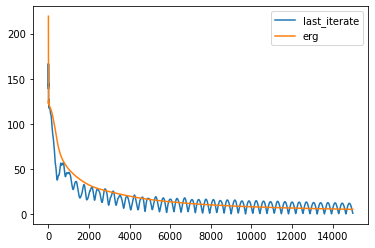

In [592]:
start = 0
plt.plot(cons[start:], label='last_iterate')
plt.plot(cons_erg[start:], label='erg')
plt.legend()
# plt.xlim(4000, None)
# plt.ylim(0, 10)

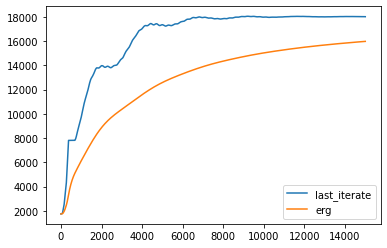

In [593]:
plt.plot(fs_log[start:], label='last_iterate')
plt.plot(fs_log_erg[start:], label='erg')
plt.legend()


In [197]:
from scipy.optimize import minimize, LinearConstraint, Bounds
x_dim = nodes + gens
bounds = Bounds([-np.pi * 20]*nodes + [20, 50], [np.pi * 20]*nodes + [200, 200])
x0 = np.array([0] * nodes + [100, 100] )

BG = np.hstack((B, -G))
dc_pf_constraint = LinearConstraint(BG, -D, -D) 
flow_constraint = LinearConstraint(F, -fmax, fmax) 

e1 = np.zeros(x_dim)
e1[0] = 1
teta_ref_constraint = LinearConstraint(e1, [0], [0]) 
res = minimize(f, x0, method='trust-constr', jac=df,
               constraints=[dc_pf_constraint, flow_constraint, teta_ref_constraint],
#                constraints=[flow_constraint],
               options={'verbose': 1, 'maxiter': 100}, bounds=bounds)

`gtol` termination condition is satisfied.
Number of iterations: 9, function evaluations: 8, CG iterations: 7, optimality: 6.35e-11, constraint violation: 5.68e-14, execution time: 0.037 s.


In [148]:
res

 barrier_parameter: 0.020000000000000004
 barrier_tolerance: 0.020000000000000004
          cg_niter: 7
      cg_stop_cond: 1
            constr: [array([-1.42108547e-14, -5.67693951e-14, -1.50000000e+02, -1.50000000e+02,
        5.68434189e-14, -1.00000000e+01]), array([-46.66674661, -53.3334247 , -46.66674661,  96.6665753 ,
       103.33325339, -10.        ]), array([4.44142332e-17]), array([4.44142332e-17, 2.80000480e+01, 3.20000548e+01, 3.26667226e+01,
       2.23333973e+01, 1.00000000e+00, 1.10000171e+02, 1.99999829e+02])]
       constr_nfev: [0, 0, 0, 0]
       constr_nhev: [0, 0, 0, 0]
       constr_njev: [0, 0, 0, 0]
    constr_penalty: 1.0
  constr_violation: 5.684341886080802e-14
    execution_time: 0.028944015502929688
               fun: 18009.870000270606
              grad: array([  0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        , 173.64022955,  56.88996231])
               jac: [array([[-13.33333333,   1.66666667,   1.66666667,   0

In [60]:
np.array([np.round(BG @ res.x) , D])

array([[   0.,    0., -150., -150.,    0.,  -10.],
       [   0.,    0.,  150.,  150.,    0.,   10.]])

In [184]:
dc_pf_constraint = {'type': 'eq', 'fun':lambda x : BG @ x + D, 'jac': lambda x:BG}
teta_ref_constraint = {'type': 'eq', 'fun':lambda x : e1 @ x, 'jac': lambda x:e1}
res = minimize(f, x0, method='SLSQP', jac=df,
               constraints=[dc_pf_constraint],
#                constraints=[flow_constraint],
                bounds=bounds)



In [185]:
res

     fun: 10434.52981184437
     jac: array([  0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        , 110.97223213,  53.21308023])
 message: 'Positive directional derivative for linesearch'
    nfev: 41
     nit: 14
    njev: 10
  status: 8
 success: False
       x: array([  2.71868595,   3.08117741,   3.1329619 ,   3.14159265,
        -3.14159265,   3.14159265,  63.23300905, 183.28672832])

In [181]:
np.array([np.round(BG @ res.x) , D])

array([[-58.,  -0., -63., -63., -58.,  -4.],
       [  0.,   0., 150., 150.,   0.,  10.]])

In [180]:
np.round(BG[:,:].sum(axis=0)) , -D.sum()

(array([-0.,  0.,  0.,  0.,  0.,  0., -1., -1.]), -310.0)

In [21]:
np.diag(X.sum(axis=1))

array([[inf,  0.,  0.,  0.,  0.,  0.],
       [ 0., inf,  0.,  0.,  0.,  0.],
       [ 0.,  0., inf,  0.,  0.,  0.],
       [ 0.,  0.,  0., inf,  0.,  0.],
       [ 0.,  0.,  0.,  0., inf,  0.],
       [ 0.,  0.,  0.,  0.,  0., inf]])